# 震源メカニズム解の表現

In [2]:
import pygmt

震源メカニズムは辞書形式でデータを渡すのがわかりやすそうです．

In [3]:
meca ={
    "strike"   : [35, 15], 
    "dip"      : [45, 35], 
    "rake"     : [90, 120], 
    "magnitude": [6, 4], 
    "longitude": [135, 140],
    "latitude" : [35, 40], 
    "depth"    : [30, 400]
}

この例のように，`strike, dip, rake` が指定されると自動的にAki and Richardsフォーマットが選択されます．公式マニュアルによると，その他のフォーマットは以下のような辞書項目が設定されていれば良いようです：

| format | dictionary keys |
|:------ |:---------------- |
| `aki`  | `strike`, `dip`, `rake`, `magnitude`  |
| `gcmt`  | `strike1`, `dip1`, `rake1`, `strike2`, `dip2`, `rake2`, `mantissa`, `exponent`  |
| `mt`  | `mrr`, `mtt`, `mff`, `mrt`, `mrf`, `mtf`, `exponent`  |
| `partial`  | `strike1`, `dip1`, `strike2`, `fault_type`, `magnitude`  |
| `principal_axis` | `t_exponent`, `t_azimuth`, `t_plunge`, `n_exponent`, `n_azimuth`, `n_plunge`, `p_exponent`, `p_azimuth`, `p_plunge`, `exponent`  |

複数のメカニズム解を表現したい場合は，辞書のそれぞれのキーに対応する値をリストやタプルにします．同じ構造を持つ辞書全体のリストを一括で処理することはできないようです．（とはいえ，Pythonの `for` 構文と組み合わせればそれは容易に実現できます）


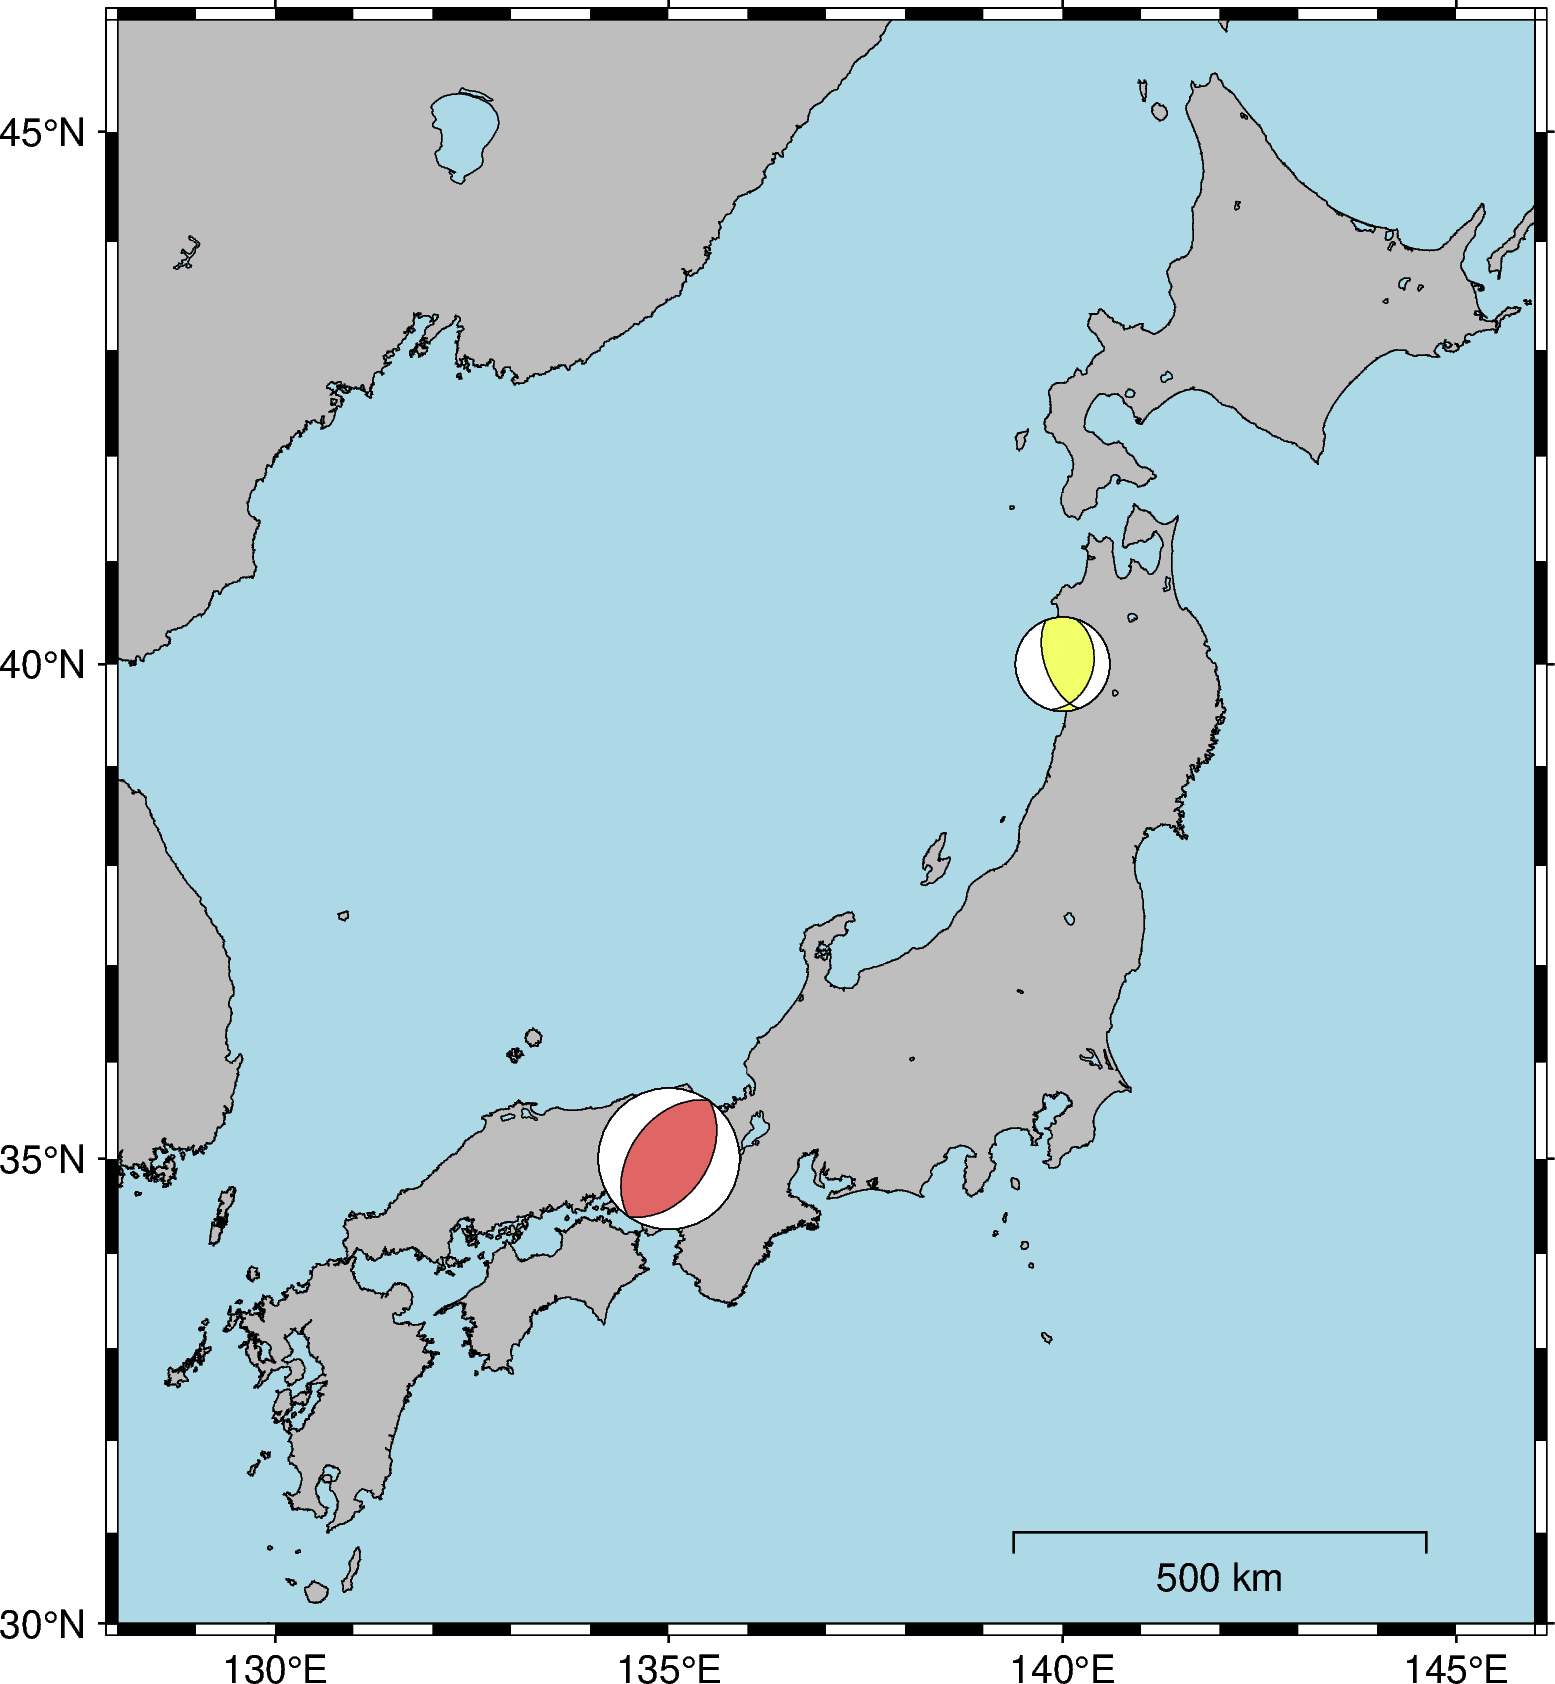

In [9]:
fig = pygmt.Figure()

fig.coast(
    projection  = 'M12c', 
    region      = [128, 146, 30, 46], 
    land        = 'grey', 
    water       = 'lightblue', 
    shorelines  = 'default,black', 
    area_thresh = 10,                           
    resolution  = 'f', 
    frame       = ['WSen', 'xaf', 'yaf'], 
    map_scale   = '142/31/31/500'
)

pygmt.makecpt(
    cmap         = 'seis',       
    series       = [0, 700, 50], 
    background   = True,         
    continuous   = True, 
    transparency = 40, 
)

fig.meca(spec  = meca, 
         scale = '1c', 
         cmap  = True, 
)

# 節面を描画するにはもういちど fig.meca を `nodal` オプションをつけて呼ぶ
fig.meca(
    spec  = meca, 
    scale = '1c', 
    pen   = 'default,black', 
    nodal = '0'
)

fig.show()